Ref.: http://blog.keras.io/building-autoencoders-in-keras.html

The encoder will consist of a stack of Convolution2d and MaxPooling2D layers, where max pooling is used for spatial down-sampling. The decoder will comprise a stack of Convolution2D and UpSampling2D layers.

Reddit ELI5: https://www.reddit.com/r/explainlikeimfive/comments/49u87u/eli5_what_is_a_convolutional_neural_network/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist

#My own imports to try out on bbbc017
import sys
import os
os.chdir("/Users/don/Documents/hcs")
sys.path.append("/Users/don/Documents/PyModules")

import os
from skimage import io, filters, util, data, img_as_float
import skynet.patch_extraction as pex

Using Theano backend.


In [13]:
# Load data. Normalize all values to between 0 and 1
# It seems that labels are discarded, because they're not needed?
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))
print(x_train.shape)
print(x_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


From:http://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks<br>
In the neural network terminology:
- one epoch = one forward pass and one backward pass of all the training examples
- batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
- number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.


In [19]:
# Now let's define the model. 
# Set input dimensions:
input_img = Input(shape=(1, 28, 28))

# Encoder: define a chain of Conv2D and MaxPooling2D layers
x = Convolution2D(16, 3, 3, 
                  activation='relu', 
                  border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, 
                  activation='relu', 
                  border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, 
                  activation='relu', 
                  border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point, the representation is (8, 4, 4) i.e. 128-dimensional

# Decoder: a stack of Conv2D and UpSampling2D layers
x = Convolution2D(8, 3, 3, 
                  activation='relu', 
                  border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, 
                  activation='relu', 
                  border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, 
                  activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, 
                        activation='sigmoid', 
                        border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [20]:
# Fit the model to MNIST
# Takes about 100s per epoch --> 83mins for 50 epochs
autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 106s - loss: 0.2348 - val_loss: 0.1867
Epoch 2/30
38400/60000 [==================>...........] - ETA: 34s - loss: 0.1797

KeyboardInterrupt: 

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
#decoded_imgs.shape (10000, 1, 28, 28)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Now let's try the same pipeline with the 8 test images of bbbc017.
Let's extract 4000 patches of shape (3, 30, 30) from the training images as a training set, and 4000 patches of shape (3, 30, 30) from the testing images as a testing set. Listdir output:
- 02490700-H05
- 02490700-L13
- 02490701-G03
- 02490701-L04
- 02490702-G03
- 02490702-H05
- 02490702-L04
- 02490702-L13

So the first four are training images, the last four are test images.

The 3 colour channels are naively compressed into 1 channel by taking the average.

In [2]:
#Load the images
path = "/Users/don/Documents/hcs/images/"
imgs_fn = os.listdir(path)

#Get a list of images in the directory given by 'path'
img_list = []
for line in imgs_fn:
    #Ignore hidden files, or at least files that start with '.'
    if not line.startswith('.') and os.path.isfile(os.path.join(path, line)):
        path_2 = path + line
        #print(path_2)
        img_list.append(img_as_float(io.imread(path_2)[:,:,:3]))

img_collection = np.array(img_list)
print(img_collection.shape)
# >> img_collection.shape (8, 840, 842, 3)
# 8 images of shape (840, 843, 3)

#Reshape, just to put the colour channels in front
img_collection2 = []
for img in img_collection:
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    img2 = np.array([R,G,B])
    img_collection2.append(img2)
    
img_collection2 = np.array(img_collection2)
print(img_collection2.shape)

del img_collection #to save space

(8, 840, 842, 3)
(8, 3, 840, 842)


In [3]:
#Get img dimensions
ch, nrows, ncols = img_collection2[0].shape
n_patches = 750
patch_len = 28 #Naively set at 28 to match MNIST, because it otherwise throws a lengthy error

patches_trg = []
#Training images: first four in img_collection2
for img in img_collection2[:4]:
    ch, nrows, ncols = img.shape
    coords = pex.generate_patch_coords(n_patches, patch_len, ncols, nrows)
    patches = np.zeros((n_patches, patch_len, patch_len))
    for i in range(n_patches):
        x, y = coords[i]
        patches[i] = np.mean(img[:,x:x+patch_len, y:y+patch_len], axis=0)
    patches_trg.append(patches)

patches_trg = np.array(patches_trg)
print(patches_trg.shape)
#Hope this works as a flatten...
patches_trg = patches_trg.reshape(4*n_patches, 1, patch_len, patch_len)
print(patches_trg.shape)

(4, 750, 28, 28)
(3000, 1, 28, 28)


In [4]:
#Get test patches
patches_test = []
#Testing images: last four in img_collection2
for img in img_collection2[4:]:
    ch, nrows, ncols = img.shape
    coords = pex.generate_patch_coords(n_patches, patch_len, ncols, nrows)
    patches = np.zeros((n_patches, patch_len, patch_len))
    for i in range(n_patches):
        x, y = coords[i]
        patches[i] = np.mean(img[:,x:x+patch_len, y:y+patch_len], axis=0)
    patches_test.append(patches)

patches_test = np.array(patches_test)
print(patches_test.shape)
#Hope this works as a flatten...
patches_test = patches_test.reshape(4*n_patches, 1, patch_len, patch_len)
print(patches_test.shape)


(4, 750, 28, 28)
(3000, 1, 28, 28)


In [5]:
# Same as the code above, but with some params changed
# Now let's define the model. 

# Set input dimensions:
input_img = Input(shape=(1, patch_len, patch_len))

# Encoder: define a chain of Conv2D and MaxPooling2D layers
x = Convolution2D(128, 3, 3, 
                  activation='relu', 
                  border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(64, 3, 3, 
                  activation='relu', 
                  border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(64, 3, 3, 
                  activation='relu', 
                  border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point, the representation is (8, 4, 4) i.e. 128-dimensional

# Decoder: a stack of Conv2D and UpSampling2D layers
x = Convolution2D(64, 3, 3, 
                  activation='relu', 
                  border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(64, 3, 3, 
                  activation='relu', 
                  border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(128, 3, 3, 
                  activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, 
                        activation='sigmoid', 
                        border_mode='same')(x)

autoencoder2 = Model(input_img, decoded)
autoencoder2.compile(optimizer='adadelta', loss='mse')

In [6]:
# Fit the model to patches
t0 = time.time()

autoencoder2.fit(patches_trg, patches_trg,
                nb_epoch=100,
                batch_size=20,
                shuffle=True,
                validation_data=(patches_test, patches_test))

dt = time.time() - t0
m, s = divmod(dt, 60)
h, m = divmod(m, 60)
print("All done in %d:%02d:%02d" % (h, m, s))

Train on 3000 samples, validate on 3000 samples
Epoch 1/100
3000/3000 [==============================] - 51s - loss: 0.0417 - val_loss: 0.0255
Epoch 2/100
3000/3000 [==============================] - 51s - loss: 0.0250 - val_loss: 0.0287
Epoch 3/100
3000/3000 [==============================] - 51s - loss: 0.0217 - val_loss: 0.0256
Epoch 4/100
3000/3000 [==============================] - 51s - loss: 0.0197 - val_loss: 0.0183
Epoch 5/100
3000/3000 [==============================] - 51s - loss: 0.0184 - val_loss: 0.0174
Epoch 6/100
3000/3000 [==============================] - 51s - loss: 0.0171 - val_loss: 0.0174
Epoch 7/100
3000/3000 [==============================] - 51s - loss: 0.0164 - val_loss: 0.0198
Epoch 8/100
3000/3000 [==============================] - 51s - loss: 0.0159 - val_loss: 0.0171
Epoch 9/100
3000/3000 [==============================] - 51s - loss: 0.0151 - val_loss: 0.0163
Epoch 10/100
3000/3000 [==============================] - 51s - loss: 0.0148 - val_loss: 0.0160
E

In [8]:
decoded_imgs = autoencoder2.predict(patches_test)
print(decoded_imgs.shape)

(3000, 1, 28, 28)


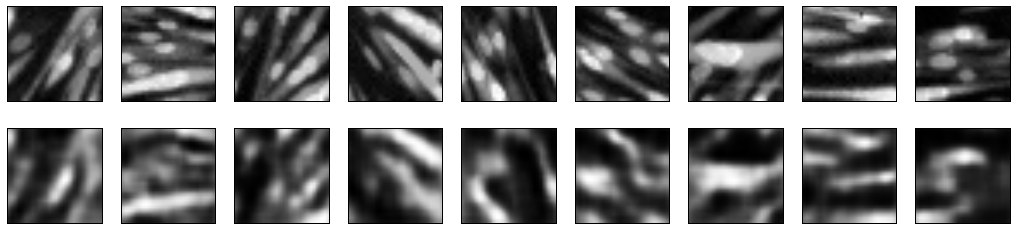

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(patches_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()